In [1]:
#include("../../hw2/nicole/nicole_hw2_functions.jl")
#using nicole_hw2_functions
using DataFrames
using PyPlot
using LsqFit

# FUNCTIONS
# get_period from nicole_hw2_functions because include isn't working?
function get_period(time,RV)
    t_N = 100
    per_array = linspace(10.0,14.0,t_N)
    chi = zeros(t_N)
    for i in range(1,t_N)
        per_rems  = mod(time,per_array[i])
        per_where = sortperm(per_rems)
        rv_rems   = RV[per_where]
        sum = 0.0
        for j in range(2,length(time)-2)
            sum += (rv_rems[j]-rv_rems[j-1])^2.
        end
        chi[i] = sum
    end
    return per_array[indmin(chi)]
end

function area(radius,distance)
    A = (radius^2. * acos(distance/radius)) - distance*sqrt(radius^2. - distance^2.)
end

function transit_area(R_s,r_p,d)
    if d >= (R_s + r_p)
        B = 0.0
        return B
    end
    if d <= (R_s - r_p)
        B = pi*r_p^2.
        return B
    end
    d1    = (d^2. + R_s^2. - r_p^2.)/(2.*d)
    d2    = (d^2. + r_p^2. - R_s^2.)/(2.*d)
    B_new = area(R_s,d1) + area(r_p,d2)
    B = B_new
    return B
end

function transit_flux(time,params)
    b,v_tid,T0,T,P,k,inc,R_s,a = params
    flux = zeros(length(time))

    for i in range(1,length(time))
        # Linear distance calculation
        #v = 2*pi*a/(P*R_s)
        #d_p = sqrt((b^2) + (v_tid*(time-T0-(n*P)))^2)
            
        # More rigorous distance calculation
        x = (a/R_s)*sin((2.*pi/P)*(time[i] - T0))
        y = (a/R_s)*cos(inc)*cos((2.*pi/P)*(time[i] - T0)) 
            
        d_p = sqrt((x^2.) + (y^2.))
        A_p = transit_area(1.0,k,d_p)
        flux[i] = 1. - A_p/pi
    end 
    return flux
end

transit_flux (generic function with 1 method)

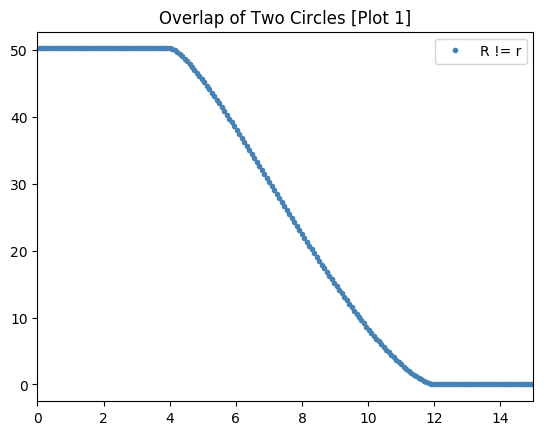

In [2]:
# Computer overlap of two circles as a function of their distance
# d : separation between the circles
# r : radius of each circle (assumed to be same for both)
# R : secondary radius if different
# A : area of overlap

R = 8
r = 4
d = linspace(0,15,200)

B = zeros(200)
for j in range(1,length(d)-1)
    B_new = transit_area(R,r,d[j])
    B[j] = B_new
end

plot(d,B,marker="o",linestyle="None",color="SteelBlue",markersize=3,label="R != r")
title("Overlap of Two Circles [Plot 1]")
xlim(0,15)
legend()
show()

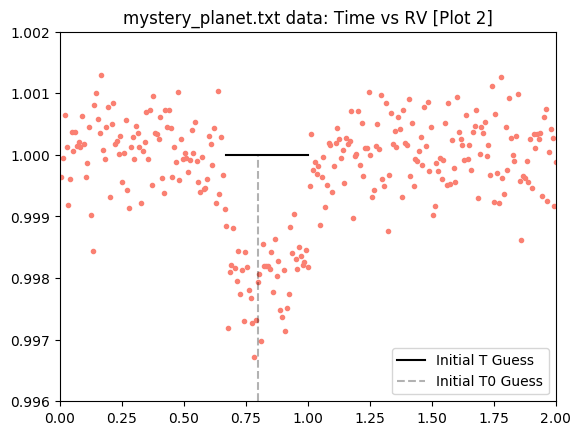

In [3]:
# Read in data: mystery_planet2.txt, time, RV (m/s), error (m/s)
# Read in our data table
planet_data = readtable("mystery_planet2.txt", separator =' ')

N = length(planet_data[1])
time   = convert(Array,planet_data[1])  
RV     = convert(Array,planet_data[2]) # m/s
RV_err = convert(Array,planet_data[3]) # m/s

# Plot initial arrays of data and estimate (by eye) T0 and T values
plot(time,RV/mean(RV),marker="o",linestyle="None",color="Salmon",markersize=3)
plot([0.67,1.0],[1.0,1.0],linestyle="-",color="Black",label="Initial T Guess")
plot([0.8,0.8],[0.996,1.0],linestyle="--",color="Black",label="Initial T0 Guess",alpha=0.3)
title("mystery_planet.txt data: Time vs RV [Plot 2]")
ylim(0.996,1.002)
legend(loc=4)
xlim(0,2)
show()

[0.5,5.7735,0.8,0.3,12.1818,0.0447214,1.5708,1.0,11.1936]


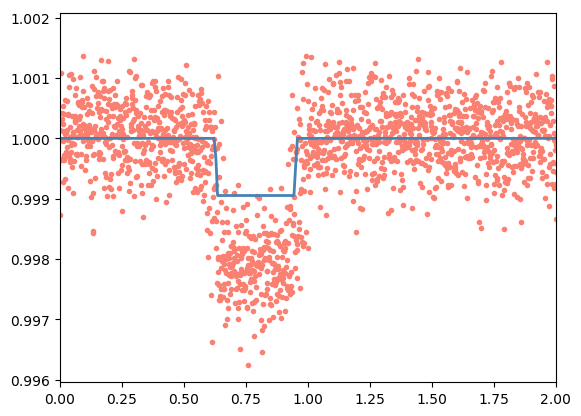

In [4]:
# Need to initialize Period by using function from HW#2
# Using this instead of bls.jl
P = get_period(time,RV)

R_s   = 1.               # Everything should be in R_s units
k     = sqrt(0.002)      # r_p/R_s [unitless]
b     = 0.5              # Assumed value from discussion for impact parameter 
T0    = 0.8              # Initial guess for position of first transit from plot 2
T     = 0.3              # Initial guess for duration of transit from plot 2
v_tid = 2*sqrt(1-b^2)/T  # [1/s] 2*pi*a/(P*R_s)  
a     = v_tid*P/(2*pi)   # [R_s] 
inc   = pi/2.            # [radians]

# Parameters: [impact parameter, dimensionless velocity, initial transit time, 
#              transit time, period, ratio of radii [r_p/R_s], inclination, 
#              stellar radius, semi major axis]
params = [b,v_tid,T0,T,P,k,inc,R_s,a]
println(params)

# Fold over new period
time_new    = rem(time,P)
plot(time_new,RV/mean(RV),marker="o",linestyle="None",color="Salmon",markersize=3)

# Make sure transit_flux function is working
#test = transit_flux(time_new,params)

# Apply curve_fit over function and input parameters
fit  = curve_fit(transit_flux,time_new,RV/mean(RV),RV_err,params)
tfit = transit_flux(time_new,fit.param) 

# Overplot best fit transit on folded data
plot(time_new[1:500],tfit[1:500],marker="None",linestyle="-",color="SteelBlue",linewidth=2)
xlim(0,2)
show()

In [5]:
# Print out the final best fit parameters for the transit
#println(fit.param)
println("Final Fit Parameters for Mystery Planet 2")
println("Impact Parameter:       ",fit.param[1])
println("Dimensionless Velocity: ",round(fit.param[2],2))
println("Initial Transit Time:   ",round(fit.param[3],2))
println("Transit Time:           ",fit.param[4])
println("Period:                 ",round(fit.param[5],2))
println("Depth:                  ",round((fit.param[6])^2.,4))
println("Semi-major Axis:        ",round(fit.param[9],2))

Final Fit Parameters for Mystery Planet 2
Impact Parameter:       0.5
Dimensionless Velocity: 5.77
Initial Transit Time:   0.79
Transit Time:           0.3
Period:                 12.22
Depth:                  0.0009
Semi-major Axis:        14.32
